### Implementation of schemes for the Heat Equation:
- The Forward Time Centered Space Method(Explicit);
- The Backward Time Centered Space Method(Implicit);
- Crank-Nicolson(Implicit);


\begin{equation}
    \partial_{t}u = \partial^2_{x}u , \quad 0 < x < 1, \quad t > 0 \\
\end{equation}
\begin{equation}
    \partial_{x}u(0,t) = 0, \quad \partial_x{u}(1,t) = 0\\
\end{equation}
\begin{equation}
    u(x, 0) = 1/2 + cos(2 \pi x) - 1/2 cos(3 \pi x)
\end{equation}

### Exact Solution: 
\begin{equation}
    u(x,t) = \frac{1}{2} + e^{-4\pi^2t}cos(2\pi x) - \frac{1}{2} e^{-9\pi^2t}cos(3\pi x)
\end{equation}

In [7]:
import math, sys 
import numpy as np
import sympy as sp
from scipy import sparse
from sympy import fourier_series, pi
from scipy.fftpack import *
from scipy.sparse import diags
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from os import path
count = 0

In [8]:
def Solution(x, t):
    return 1.0/2.0 + np.exp(-4*np.square(np.pi)*t)*np.cos(2*np.pi*x) - 1.0/2.0*np.exp(-9*np.square(np.pi)*t)*np.cos(3*np.pi*x)

In [9]:
def surfaceplot(U, Uexact, tspan, xspan, M): 
    N = M**2
    X, T = np.meshgrid(tspan, xspan)
    
    fig = plt.figure(figsize=plt.figaspect(0.3))
    
    ax = fig.add_subplot(1, 4, 1,projection='3d')
    surf = ax.plot_surface(X, T, Uexact, linewidth=0, cmap=cm.jet, antialiased=True)
    ax.set_title('Exact Solution')
    ax.set_xlabel('Time')
    ax.set_ylabel('Space')
    ax.set_zlabel('U')
    
    ax1 = fig.add_subplot(1, 4, 2,projection='3d')
    surf = ax1.plot_surface(X, T, U, linewidth=0, cmap=cm.jet, antialiased=True)
    ax1.set_title('Approximation')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Space')
    ax1.set_zlabel('U')
    

    ax2 = fig.add_subplot(1, 4, 3, projection='3d')
    surf2 = ax2.plot_surface(X, T, abs(Uexact-U), linewidth=0, cmap=cm.jet, antialiased=True)
    ax2.set_title('Absolute Error')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Space')
    ax2.set_zlabel('Error')

    Urelative = np.zeros((M, N))

    for i in range(0, M):
        for j in range(0, N):
              Urelative[i][j] = abs((Uexact[i][j] - U[i][j])/Uexact[i][j])
    
          
    ax3 = fig.add_subplot(1, 4, 4, projection='3d')
    surf3 = ax3.plot_surface(X, T, Urelative, linewidth=0, cmap=cm.jet, antialiased=True)
    ax3.set_title('Relative Error')
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Space')
    ax3.set_zlabel('Error')
    
    plt.tight_layout()
    ax.view_init(30,230)
    ax1.view_init(30,230)
    ax2.view_init(30,230)
    ax3.view_init(30,230)
    
    fig.savefig(path.join("plot_METHOD{0}.png".format(count)),dpi=600)
    plt.draw()
    

In [10]:
def ExactSolution(M, T = 0.5, L = 1):
    N = (M**2) 

    xspan = np.linspace(0, L, M)
    tspan = np.linspace(0, T, N)
    
    Uexact = np.zeros((M, N))
    
    for i in range(0, M):
        for j in range(0, N):
            Uexact[i][j] = Solution(xspan[i], tspan[j])
    
    return (Uexact, tspan, xspan)

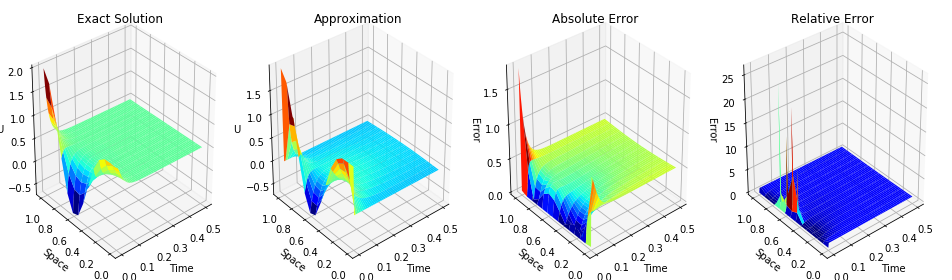

In [11]:
def ForwardEuler(M, lambd, T = 0.5, L = 1, k = 1): 

    N = (M**2) 

    x0, xL = 0, L

    dx = (xL - x0)/(M-1)

    t0, tF = 0, T

    dt = (tF - t0)/(N-1)

    xspan = np.linspace(x0, xL, M)
    tspan = np.linspace(t0, tF, N)

    U = np.zeros((M, N))

    U[:,0] = (1.0/2.0)+ np.cos(2.0*np.pi*xspan) - (1.0/2.0)*np.cos(3*np.pi*xspan)


    f = np.arange(1, N+1)
    f = (-3*U[0,:] + 4*U[1,:] - U[2,:])/2*dx
    U[0,:] = (4*U[1,:] - U[2,:])/3
    
    g = np.arange(1, N+1)
    g = (-3*U[-1,:] + 4*U[-2,:] - U[-3,:])/2*dx
    U[-1,:] = (4*U[-2,:] - U[-3,:])/3
    
    for k in range(0, N-1):
        for i in range(1, M-1):
            U[i, k+1] = lambd*U[i-1, k] + (1-2*lambd)*U[i,k] + lambd*U[i+1,k] 
    
    return (U, tspan, xspan)

U, tspan, xspan = ForwardEuler(M = 14, lambd = 1.0/6.0)
Uexact, x, t = ExactSolution(M = 14)
surfaceplot(U, Uexact, tspan, xspan, M = 14)

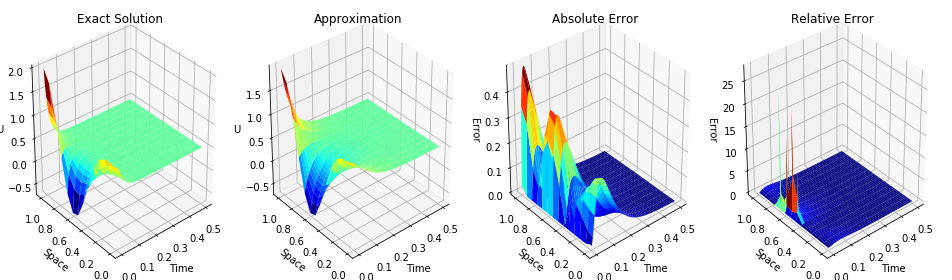

In [12]:
def BackwardEuler(M, lambd, T = 0.5, L = 1, k = 1):

    N = (M**2) 
    x0, xL = 0, L 

    dx = (xL - x0)/(M-1)

    t0, tF = 0, T 

    dt = (tF - t0)/(N-1)

    a = 1 + 2*lambd

    xspan = np.linspace(x0, xL, M)
    tspan = np.linspace(t0, tF, N)

    main_diag = (1 + 2*lambd)*np.ones((1,M))
    off_diag = -lambd*np.ones((1, M-1))
    a = main_diag.shape[1]
    diagonals = [main_diag, off_diag, off_diag]

    A = sparse.diags(diagonals, [0,-1,1], shape=(a,a)).toarray()
    A[0,1] = -2*lambd
    A[M-1,M-2] = -2*lambd

    U = np.zeros((M, N))
    
    U[:,0] = (1.0/2.0)+ np.cos(2.0*np.pi*xspan) - (1.0/2.0)*np.cos(3*np.pi*xspan)

    f = np.arange(1, N+1) 
    f = U[0,:] = (4*U[1,:] - U[2,:])/3
    
    g = np.arange(1, N+1) 
    g = U[-1,:] = (4*U[-2,:] - U[-3,:])/3

    for i in range(1, N):
        c = np.zeros((M-2,1)).ravel()
        b1 = np.asarray([2*lambd*dx*f[i], 2*lambd*dx*g[i]])
        b1 = np.insert(b1, 1, c)
        b2 = np.array(U[0:M, i-1])
        b = b1 + b2 
        U[0:M, i] = np.linalg.solve(A,b)  
   
    return (U, tspan, xspan)

U, tspan, xspan = BackwardEuler(M = 14, lambd = 1.0/6.0)
Uexact, x, t = ExactSolution(M = 14)
surfaceplot(U, Uexact, tspan, xspan, M = 14)

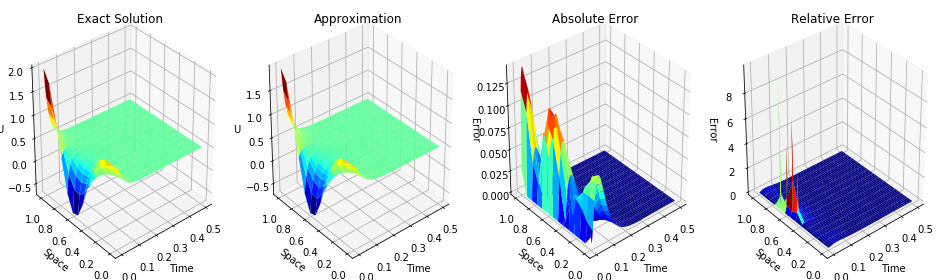

In [13]:
def CrankNicolson(M, lambd, T = 0.5, L = 1, k = 1):
    N = (M**2) 
    x0, xL = 0, L
    dx = (xL - x0)/(M-1)

    t0, tF = 0, T 

    dt = (tF - t0)/(N-1)

    a0 = 1 + 2*lambd
    c0 = 1 - 2*lambd

    xspan = np.linspace(x0, xL, M)
    tspan = np.linspace(t0, tF, N)

    maindiag_a0 = a0*np.ones((1,M))
    offdiag_a0 = (-lambd)*np.ones((1, M-1))

    maindiag_c0 = c0*np.ones((1,M))
    offdiag_c0 = lambd*np.ones((1, M-1))

    a = maindiag_a0.shape[1]
    diagonalsA = [maindiag_a0, offdiag_a0, offdiag_a0]
    A = sparse.diags(diagonalsA, [0,-1,1], shape=(a,a)).toarray()
    
    A[0,1] = (-2)*lambd
    A[M-1,M-2] = (-2)*lambd

    c = maindiag_c0.shape[1]
    diagonalsC = [maindiag_c0, offdiag_c0, offdiag_c0]
    
    Arhs = sparse.diags(diagonalsC, [0,-1,1], shape=(c,c)).toarray()
    Arhs[0,1] = 2*lambd
    Arhs[M-1,M-2] = 2*lambd

    U = np.zeros((M, N))

    U[:,0] = (1.0/2.0)+ np.cos(2.0*np.pi*xspan) - (1.0/2.0)*np.cos(3*np.pi*xspan)


    f = np.arange(1, N+1) 
    f = U[0,:] = (4*U[1,:] - U[2,:])/3
    
    g = np.arange(1, N+1) 
    g = U[-1,:] = (4*U[-2,:] - U[-3,:])/3
    
    for k in range(1, N):
        ins = np.zeros((M-2,1)).ravel()
        b1 = np.asarray([4*lambd*dx*f[k], 4*lambd*dx*g[k]])
        b1 = np.insert(b1, 1, ins)
        b2 = np.matmul(Arhs, np.array(U[0:M, k-1]))
        b = b1 + b2  
        U[0:M, k] = np.linalg.solve(A,b)  
    
    return (U, tspan, xspan)

U, tspan, xspan = CrankNicolson(M = 14, lambd = 1.0/6.0)
Uexact, x, t = ExactSolution(M = 14)
surfaceplot(U, Uexact, tspan, xspan, M = 14)

<---- M =  8 , N =  64 , Lambda =  2 ---->
<---- M =  8 , N =  64 , Lambda =  0.5 ---->
<---- M =  8 , N =  64 , Lambda =  0.17 ---->
<---- M =  10 , N =  100 , Lambda =  2 ---->
<---- M =  10 , N =  100 , Lambda =  0.5 ---->
<---- M =  10 , N =  100 , Lambda =  0.17 ---->
<---- M =  14 , N =  196 , Lambda =  2 ---->
<---- M =  14 , N =  196 , Lambda =  0.5 ---->
<---- M =  14 , N =  196 , Lambda =  0.17 ---->


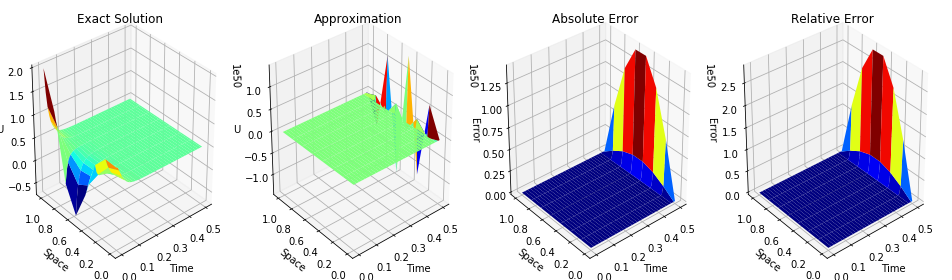

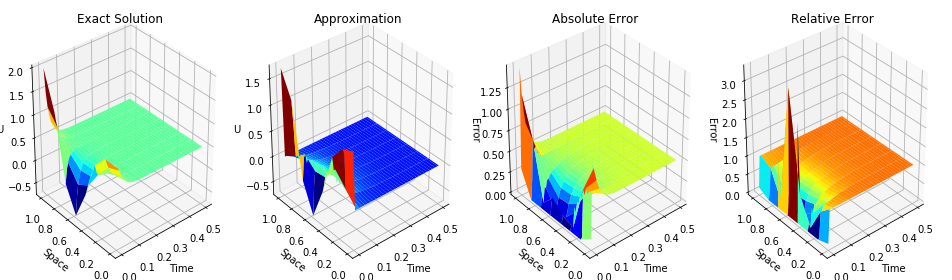

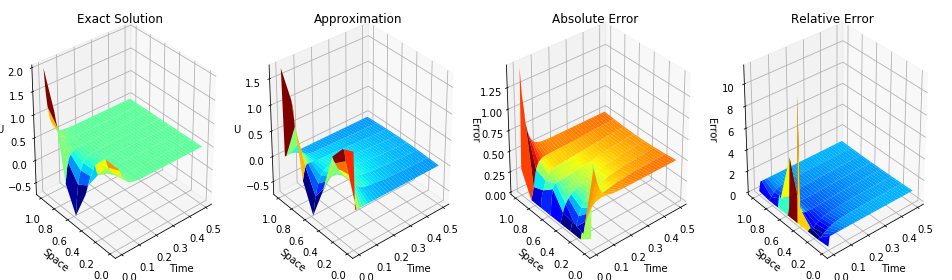

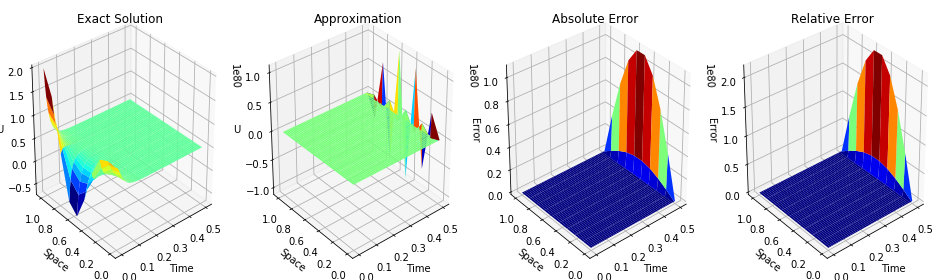

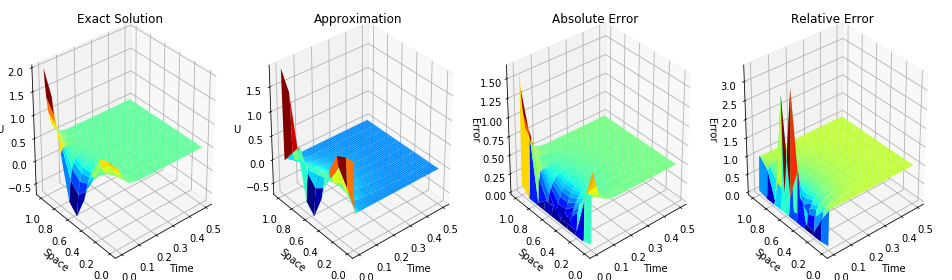

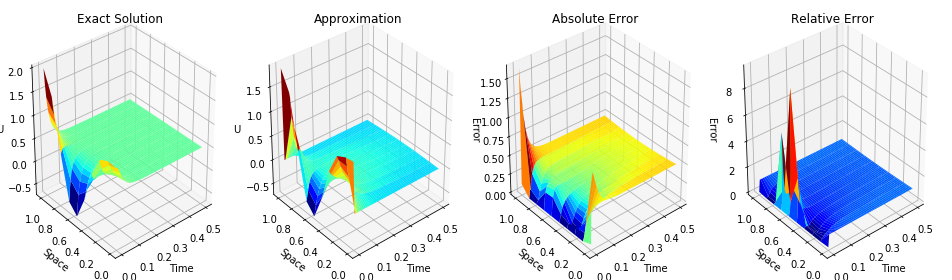

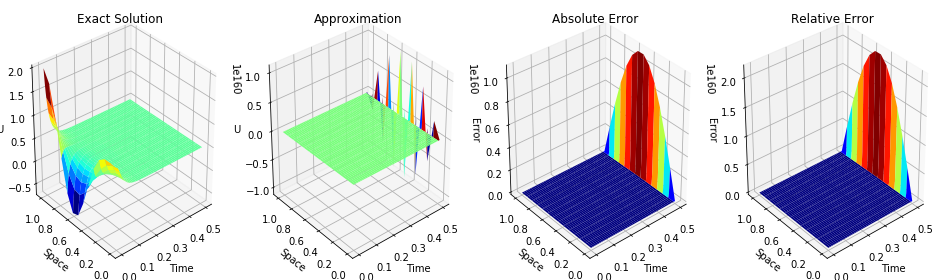

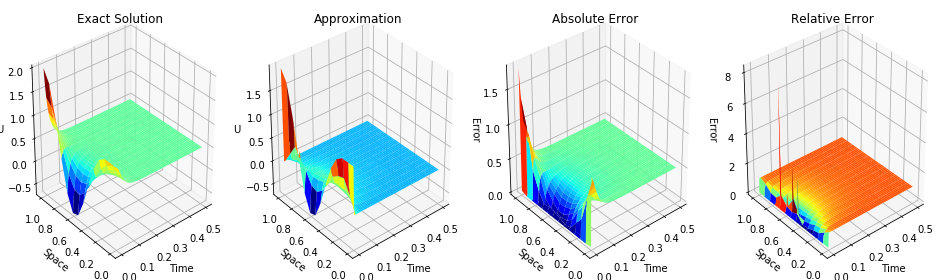

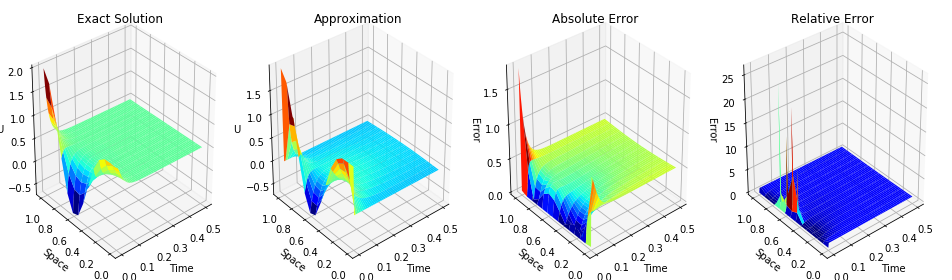

In [14]:

lambd = [2, 1.0/2.0, 1.0/6.0]
M = [8, 10, 14]
#Add plots using M = 4, 8, 10, 12, 14 

count = 0

for i in range(len(M)):
    for j in range(len(lambd)):
        Uexact, x, t = ExactSolution(M[i])
        N = M[i]**2
        U_ftcs, tspanf, xspanf = ForwardEuler(M[i], lambd[j])
        print("<---- M = ", M[i],", N = ", M[i]**2,", Lambda = ",round(lambd[j],2),"---->")
        surfaceplot(U_ftcs, Uexact, tspanf, xspanf, M[i])
        count+=1 

<---- M =  8 , N =  64 , Lambda =  2 ---->
<---- M =  8 , N =  64 , Lambda =  0.5 ---->
<---- M =  8 , N =  64 , Lambda =  0.17 ---->
<---- M =  10 , N =  100 , Lambda =  2 ---->
<---- M =  10 , N =  100 , Lambda =  0.5 ---->
<---- M =  10 , N =  100 , Lambda =  0.17 ---->
<---- M =  14 , N =  196 , Lambda =  2 ---->
<---- M =  14 , N =  196 , Lambda =  0.5 ---->
<---- M =  14 , N =  196 , Lambda =  0.17 ---->


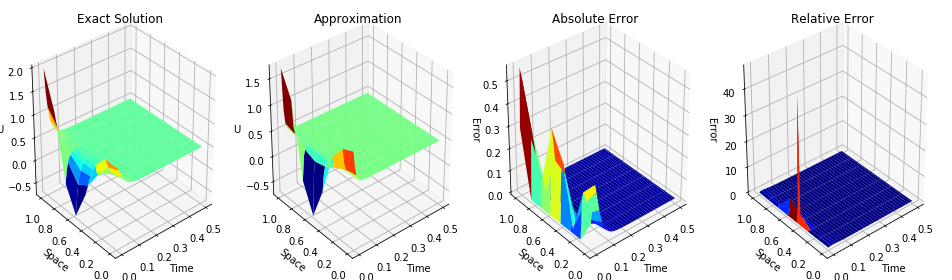

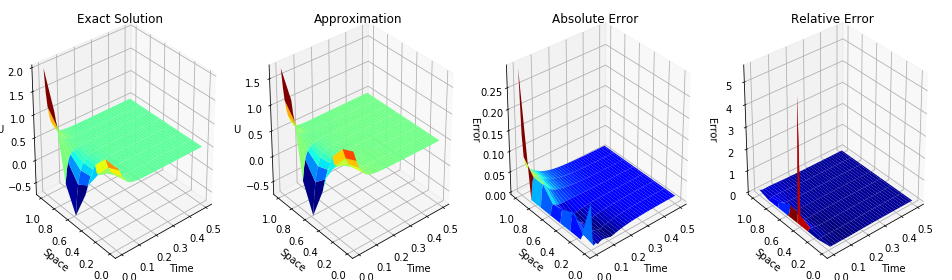

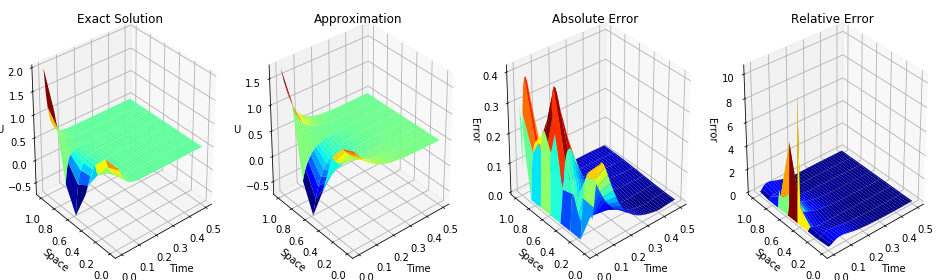

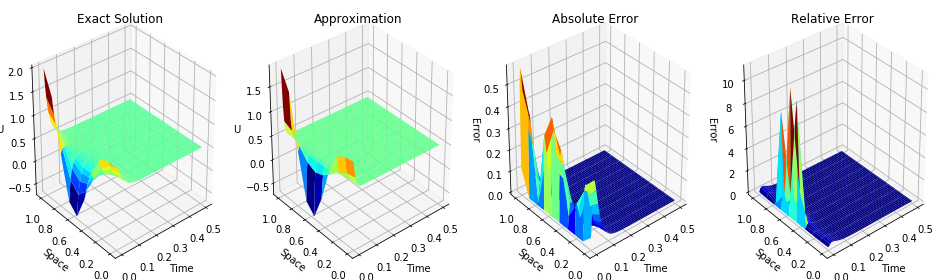

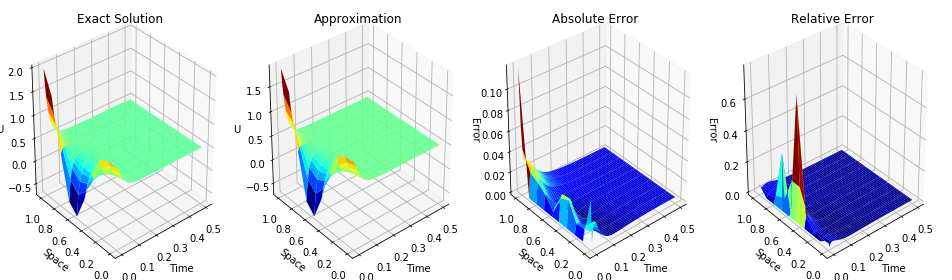

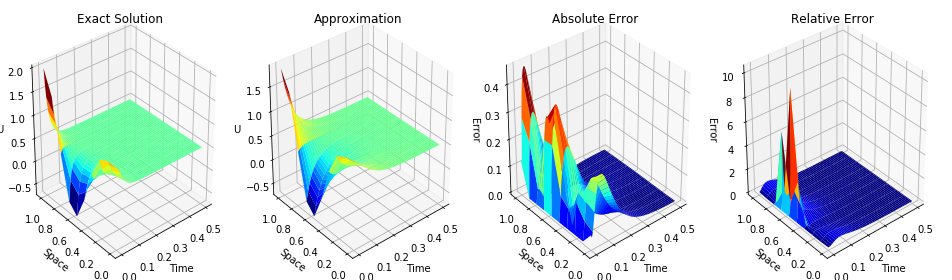

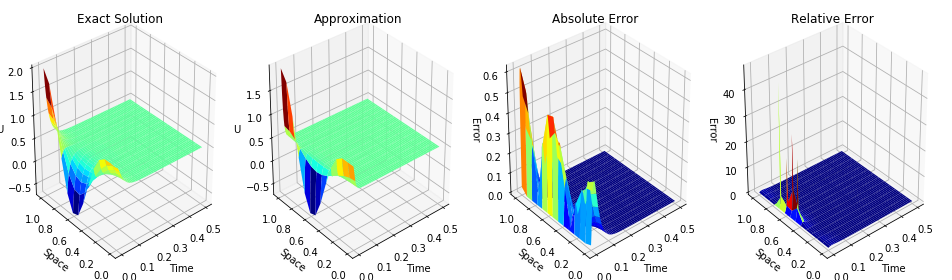

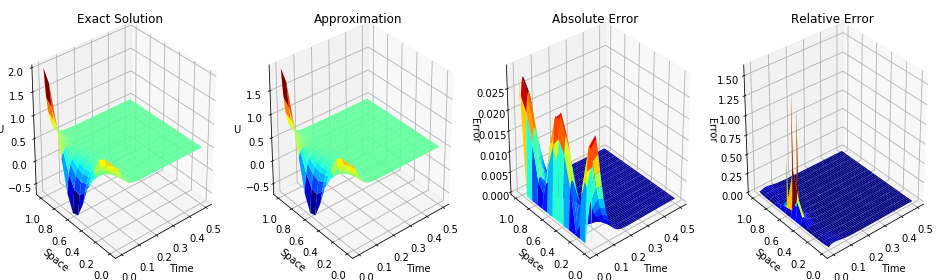

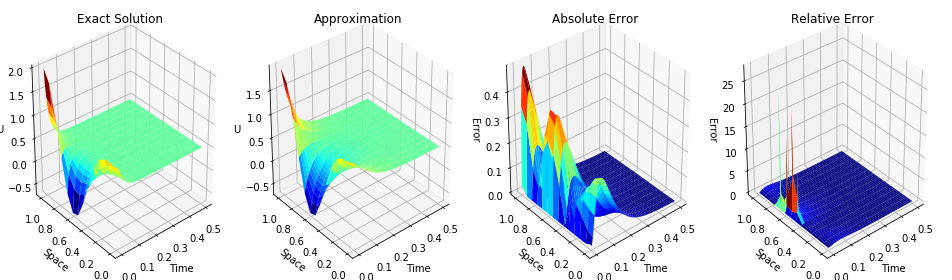

In [15]:
for i in range(len(M)):
    for j in range(len(lambd)):
        Uexact, x, t = ExactSolution(M[i])
        print("<---- M = ", M[i],", N = ", M[i]**2,", Lambda = ",round(lambd[j],2),"---->")
        U_btcs, tspanb, xspanb = BackwardEuler(M[i], lambd[j])
        surfaceplot(U_btcs, Uexact, tspanb, xspanb, M[i])
        count+=1

<---- M =  8 , N =  64 , Lambda =  2 ---->
<---- M =  8 , N =  64 , Lambda =  0.5 ---->
<---- M =  8 , N =  64 , Lambda =  0.17 ---->
<---- M =  10 , N =  100 , Lambda =  2 ---->
<---- M =  10 , N =  100 , Lambda =  0.5 ---->
<---- M =  10 , N =  100 , Lambda =  0.17 ---->
<---- M =  14 , N =  196 , Lambda =  2 ---->
<---- M =  14 , N =  196 , Lambda =  0.5 ---->
<---- M =  14 , N =  196 , Lambda =  0.17 ---->


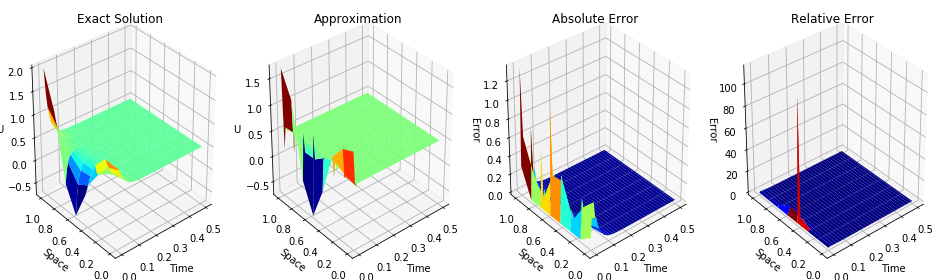

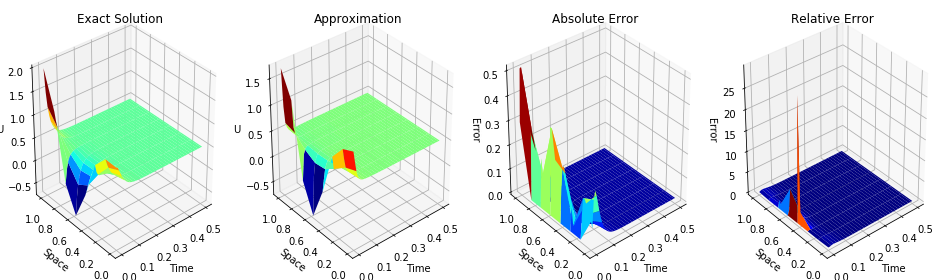

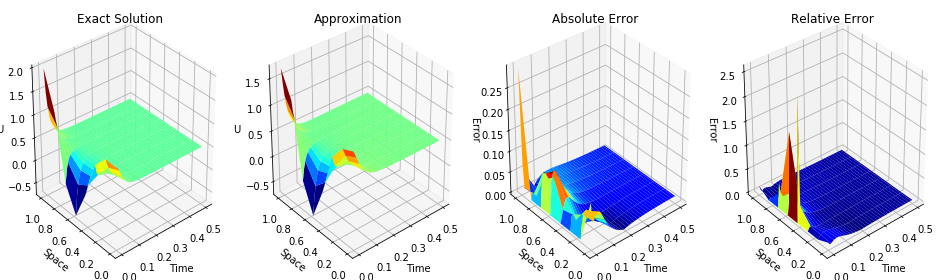

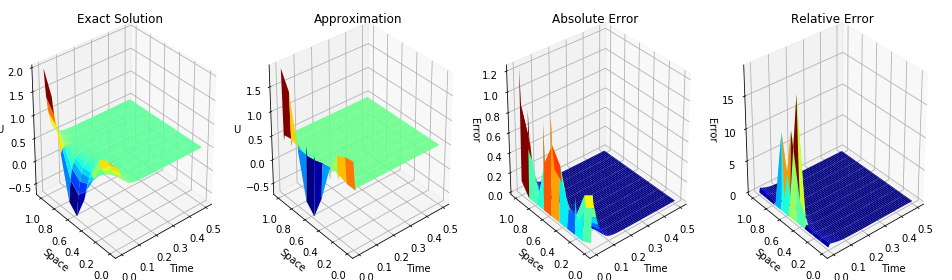

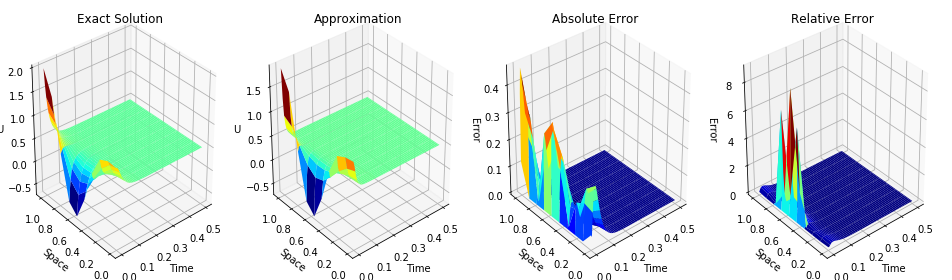

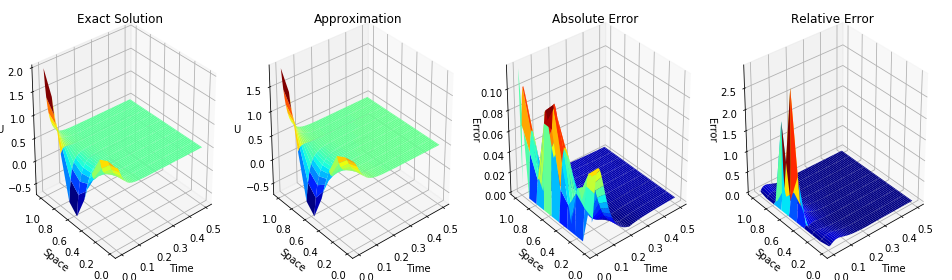

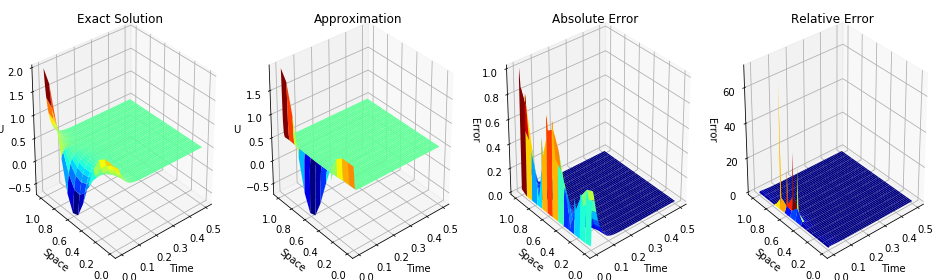

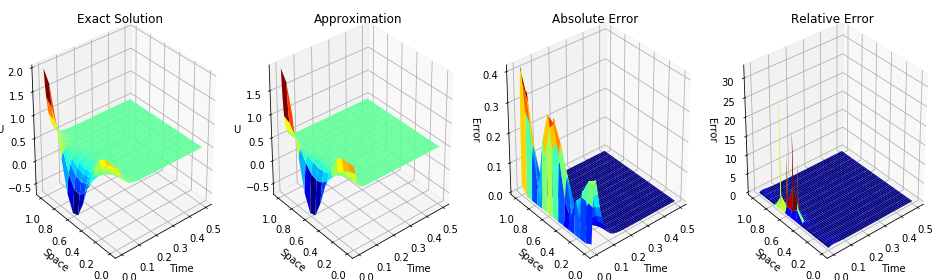

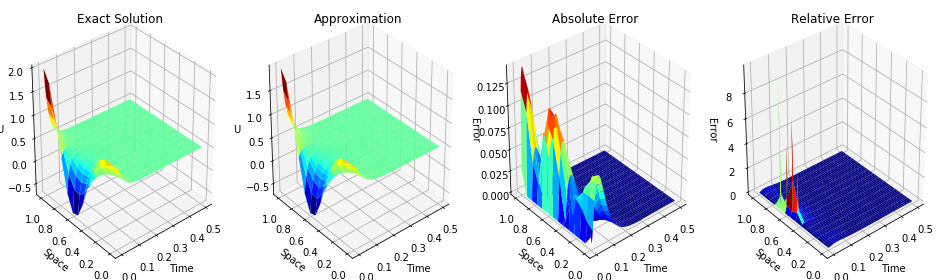

In [16]:
lambd = [2, 1.0/2.0, 1.0/6.0]
M = [8, 10, 14]

for i in range(len(M)):
    for j in range(len(lambd)):
        Uexact, x, t = ExactSolution(M[i])
        
        print("<---- M = ", M[i],", N = ", M[i]**2,", Lambda = ",round(lambd[j],2),"---->")
        U_cn, tspanc, xspanc = CrankNicolson(M[i], lambd[j])
        surfaceplot(U_cn, Uexact, tspanc, xspanc,M[i])
        count+=1

In [17]:
lambd = [2, 1.0/2.0, 1.0/6.0]
M = [4, 8, 10, 12, 14]

for i in range(len(M)):
    for j in range(len(lambd)):
        Uexact, t, x = ExactSolution(M[i])
        U_ftcs, tspanf, xspanf = ForwardEuler(M[i], lambd[j])
        U_btcs, tspanb, xspanb = BackwardEuler(M[i], lambd[j])
        U_cn, tspanc, xspanc = CrankNicolson(M[i], lambd[j])
        
        print("<---- M = ", M[i],", N = ", M[i]**2,", Lambda = ",round(lambd[j],2),"---->")
        print("FTCS error: ",abs(Uexact[:,-2] - U_ftcs[:,-2])) 
        print("FTCS: ", np.nanmax(abs(Uexact[:,-2] - U_ftcs[:,-2]))) 
        
        print("\nBTCS error: ",abs(Uexact[:,-2] - U_btcs[:,-2]))
        print("BTCS: ", np.nanmax(abs(Uexact[:,-2] - U_btcs[:,-2])))
        
        print("\nCN error: ",abs(Uexact[:,-2] - U_cn[:,-2]))
        print("CN: ", np.nanmax(abs(Uexact[:,-2] - U_cn[:,-2])))
        print("<--------------------------------------------------->\n\n")

<---- M =  4 , N =  16 , Lambda =  2 ---->
FTCS error:  [5.0000001e-01 1.0172526e+09 1.0172526e+09 5.0000001e-01]
FTCS:  1017252604.6666675

BTCS error:  [0.49999982 0.4999999  0.50000009 0.5000002 ]
BTCS:  0.5000001958188078

CN error:  [0.50164687 0.49835286 0.50164713 0.49835315]
CN:  0.5016471308795484
<--------------------------------------------------->


<---- M =  4 , N =  16 , Lambda =  0.5 ---->
FTCS error:  [0.50000001 0.50002034 0.49997965 0.50000001]
FTCS:  0.5000203400649708

BTCS error:  [0.49695514 0.49847754 0.50152245 0.50304488]
BTCS:  0.5030448760396337

CN error:  [0.49999984 0.49999989 0.5000001  0.50000018]
CN:  0.5000001842035238
<--------------------------------------------------->


<---- M =  4 , N =  16 , Lambda =  0.17 ---->
FTCS error:  [0.50000001 0.49995252 0.50004747 0.50000001]
FTCS:  0.5000474668010818

BTCS error:  [0.39733835 0.44860386 0.55139613 0.60266167]
BTCS:  0.6026616719837764

CN error:  [0.49200065 0.49600032 0.50399967 0.50799937]
CN:  0.